In [1]:
cd /home/makinen/repositories/IMNN_vs_BORG/

/home/makinen/repositories/IMNN_vs_BORG


In [2]:
import h5py
import jax
import jax.numpy as jnp
import optax

import flax.linen as nn
import numpy as np

import matplotlib.pyplot as plt

#from chainconsumer import ChainConsumer

import cloudpickle as pickle
import json

from nets import *
from imnn_mod import *
from utils import rotate_sim

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

def reshape_data(dat):
    realpart = dat[:, ::2, :, :]
    impart = dat[:, 1::2, :, :]

    return jnp.stack([realpart, impart], axis=-1)

In [3]:
config_path = "/data80/makinen/borg_sims_fixed/imnn_runs/two_param3/retrain2/configs.json"
with open(config_path) as f:
        configs = json.load(f)

savedir    = configs["savedir"]     # where to save shit
datadir    = configs["datadir"]     # where shit is saved
modeldir   = configs["modeldir"]
priordir   = configs["priordir"]
do_noise   = bool(configs["do_noise"])

In [4]:
### ------------- IMNN PARAMETERS -------------
θ_fid = jnp.array([0.3175, 0.800]) # CHANGE TO OmegaM=0.6
δθ = 2*jnp.array([0.05, 0.015])

θ_der = (θ_fid + jnp.einsum("i,jk->ijk", jnp.array([-1., 1.]), jnp.diag(δθ) / 2.)).reshape((-1, 2))

n_summaries = 2

n_s = 1000
n_d = 250

n_params = 2
n_summaries = n_params

In [22]:

### ------------- NEURAL NETWORK MODEL -------------

filters = (int(configs["filters"]),)*4
net_scaling = float(configs["net_scaling"])
patience = configs["patience"]
noise_scale = configs["noise_scale"]
act = "almost_leaky" #configs["act"]

if not do_noise:
    net_scaling /= 10.
else:
    net_scaling *= noise_scale



model = CNNRes3D(filters=filters, div_factor=net_scaling, out_shape=2, act=act)
key = jax.random.PRNGKey(42)

input_shape = (4, 64, 64, 2)

### ------------- DEFINE DATA AUGMENTATION SCHEME -------------
### ADD IN NOISE ON TOP OF FIELD SIMS
### NOISE VARIANCES == SIGMA^2

#if do_noise:
noise_variances = jnp.array([1.79560224e-06, 5.44858988e-06, 9.45448781e-06, 1.32736252e-05])
    
#else:
#    noise_variances = jnp.array([0., 0., 0., 0.])

@jax.jit
def noise_simulator(key, sim):
    key1,key2 = jax.random.split(key)
    # do rotations of simulations
    k = jax.random.choice(key1, jnp.array([0,1,2,3]), shape=())
    sim = rotate_sim(k, sim)

    # now add noise
    # this generates white noise across all pixels and then increases the amplitude
    # add zero noise for no-noise case
    sim += (jax.random.normal(key2, shape=(4,64,64,2)) * noise_scale * jnp.sqrt(noise_variances).reshape(4,1,1,1))
    return sim


#### ------------- SET UP IMNN -------------

optimiser = optax.adam(learning_rate=1e-4)

model_key = jax.random.PRNGKey(42)
rng, key = jax.random.split(key)

shape = (4, 64, 64, 2)

w = model.init(model_key, jax.random.normal(key, shape=shape))

In [23]:
output = model.apply(w, jax.random.normal(key, shape=shape))
output.shape

(2,)

In [24]:
np = jnp

In [25]:
# now do regression over prior with IMNN weights to hone in on OmegaM

X = jnp.load(priordir + "prior_sims_noisefree.npy")
y = jnp.load(priordir + "prior_params.npy")


X = reshape_data(X)[:, :, :, :, :]
#x = np.load("/data80/makinen/borg_sims/x_imnn.npy")
#estimates = np.array([[0.34354842, 0.7942477 ]])

In [26]:
from sklearn.model_selection import train_test_split

Xt = jax.device_put(X)
yt = jax.device_put(y)
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, random_state=0, test_size=250)

keys = jax.random.split(jax.random.PRNGKey(88), num=X_test.shape[0])
X_test = jax.vmap(noise_simulator)(keys, X_test)

In [27]:
# initialize stuff

def mynet(w, d):
    """function to set weights and use get_estimate function for regression"""
    #IMNN.set_F_statistics(w, key=key)
    return model.apply(w, d)  #

In [28]:
@jax.jit
def mse(w, x_batched, y_batched):
  # Define the squared loss for a single pair (x,y)
  def squared_error(x, y):
    pred = mynet(w, x)
    return jnp.log(jnp.inner(y-pred, y-pred) / 2.0)
  # Vectorize the previous to compute the average of the loss on all samples.
  return (jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0))

In [29]:
from tqdm import tqdm
import optax

tx = optax.adam(learning_rate=1e-3)
opt_state = tx.init(w)
loss_grad_fn = jax.value_and_grad(mse)

batch_size = 250
epochs = 100

losses = []
val_losses = []

key = jax.random.PRNGKey(99)

In [51]:
tx = optax.adam(learning_rate=5e-5)
opt_state = tx.init(w)
loss_grad_fn = jax.value_and_grad(mse)

In [59]:
pbar = tqdm(range(epochs), leave=True, position=0)

for j in pbar:
  key,rng = jax.random.split(key)

  for i in range(len(X_train) // batch_size):
    x_samples = X_train[batch_size*i:(batch_size*(i+1))]
    y_samples = y_train[batch_size*i:(batch_size*(i+1))]

    keys = jax.random.split(key, num=batch_size)
    x_samples = jax.vmap(noise_simulator)(keys, x_samples)

    loss_val, grads = loss_grad_fn(w, x_samples, y_samples)
    updates, opt_state = tx.update(grads, opt_state)
    w = optax.apply_updates(w, updates)
    if i % 10 == 0:

      val_loss, _ = loss_grad_fn(w, X_test, y_test)
      #print('loss step {}: '.format(i), loss_val)
      #print('val loss step {}: '.format(i), val_loss_val)
      
  losses.append(loss_val)
  val_losses.append(val_loss)
  pbar.set_description('epoch loss %d: %.4f, val loss: %.4f'%(j, loss_val, val_loss))

epoch loss 12: -4.9453, val loss: -4.9986:  13%|█▎        | 13/100 [03:21<22:29, 15.51s/it]

KeyboardInterrupt: 

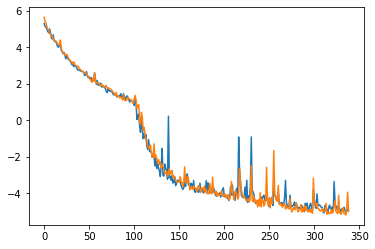

In [60]:
plt.plot(losses)
plt.plot(val_losses)
#plt.yscale('log')

In [17]:
X.shape

(10000, 4, 64, 64, 2)

In [62]:
whos

Variable                     Type                      Data/Info
----------------------------------------------------------------
Any                          _SpecialForm              typing.Any
Array                        _SpecialForm              typing.Any
AsinhLayer                   type                      <class 'nets.AsinhLayer'>
CNN3D                        type                      <class 'nets.CNN3D'>
CNNRes3D                     type                      <class 'nets.CNNRes3D'>
Callable                     _VariadicGenericAlias     typing.Callable
ConvBlock3D                  type                      <class 'nets.ConvBlock3D'>
InceptBlock                  type                      <class 'nets.InceptBlock'>
InceptBlock3D                type                      <class 'nets.InceptBlock3D'>
InceptNet                    type                      <class 'nets.InceptNet'>
InceptResBlock               type                      <class 'nets.InceptResBlock'>
InceptResNet      

In [54]:
_mynet = lambda d: mynet(w, d)

num = 2500

keys = jax.random.split(key, num=num)
noisedat = jax.vmap(noise_simulator)(keys, X[-num:])
x = jax.vmap(_mynet)(noisedat)

#key,rng = jax.random.split(key)

#keys = jax.random.split(key, num=2500)
#noisedat = jax.vmap(noise_simulator)(keys, X[2500:5000])

#x2 = jax.vmap(_mynet)(noisedat)


# key,rng = jax.random.split(key)

# keys = jax.random.split(key, num=2500)
# noisedat = jax.vmap(noise_simulator)(keys, X[5000:7500])

# x3 = jax.vmap(_mynet)(noisedat)



#x = jnp.concatenate([x1, x2, x3])

In [48]:
x.shape

(2500, 2)

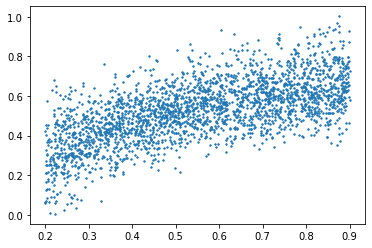

In [55]:
#plt.scatter(y[:2500, 0], xold[:, 0], s=2)
plt.scatter(y[-2500:, 0], x[:, 0], s=2)
#plt.ylim(-1, 2)

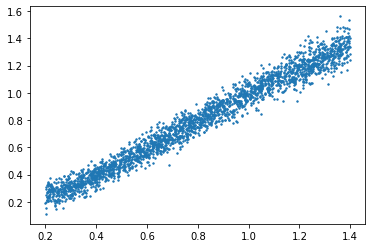

In [56]:
#plt.scatter(y[:2500, 1], xold[:, 1], s=2)
plt.scatter(y[-2500:, 1], x[:, 1], s=2)
#plt.ylim(0, 3)

In [57]:
cd /home/makinen/repositories/alfi_lensing/

/home/makinen/repositories/alfi_lensing


In [58]:
np.save("regression_x_log", x)
np.save("regression_theta_log", y[-2500:])

In [91]:
save_obj(w, '/data80/makinen/borg_sims/regression_net_w_log')

In [27]:
target_data = np.load('/data80/makinen/borg_sims/natalia_target_data.npy')

target_data.shape

(4, 64, 64, 2)

In [28]:
estimates = _mynet(jnp.expand_dims(target_data, 0))

In [29]:
estimates

DeviceArray([0.6333694 , 0.75071967], dtype=float32)

In [33]:
jnp.save('/data80/makinen/borg_sims/natalia_target_summaries', estimates)

In [25]:
#jnp.save('/data80/makinen/borg_sims/x_regression_imnn', x)

In [94]:
# get estimates on natalia's data

import numpy as np
import pylab as plt
import h5py as h5

def get_data(Ncat,N0,N1,f):
    dataR = np.zeros((Ncat,N0,N1))
    dataI = np.zeros((Ncat,N0,N1))
    
    for cat in range(0,Ncat,1):
        survey = f['lensing_catalog_'+str(cat)]['lensing_data']['lensing'][:]
        Nobs = len(survey)
        N0 = f['scalars/N0'][0]
        N1 = f['scalars/N1'][0]
        
        count = np.zeros((N0,N1))
        for nobs in range(0,Nobs,1):
            lens = survey[nobs]
            n0 = int(lens['phi'])
            n1 = int(lens['theta'])
            dataR[cat,n0,n1] = lens['shearR']
            dataI[cat,n0,n1] = lens['shearI']
            count[n0,n1] += 1
    return dataR, dataI

path = '/data80/nporqueres/borg_sims_fixed/borg_run/fixed_IA/fixed_h/'
f = h5.File(path + 'mock_data.h5', 'r')

Ncat = f['scalars/NCAT'][0]

N0 = f['scalars/N0'][0]
N1 = f['scalars/N1'][0]
N2 = f['scalars/N2'][0]

L0 = f['scalars/L0'][0]
L1 = f['scalars/L1'][0]
L2 = f['scalars/L2'][0]

dataR, dataI = get_data(Ncat, N0, N1, f)



target_data = target_data.at[::2, :, :].set(dataR)
target_data = target_data.at[1::2, :, :].set(dataI)

target_data = reshape_data(np.expand_dims(target_data, 0))

In [96]:
_mynet(target_data)

DeviceArray([0.37238947, 0.7767356 ], dtype=float32)

In [28]:
np.save('/data80/makinen/borg_sims/natalia_target_data', jnp.squeeze(target_data))